In [28]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as sklpre
import pandas as pd
from keras.datasets import boston_housing
from sklearn import datasets
from tensorflow.keras.utils import to_categorical


# 1. Matrices, Gradients, Hessians

Given the function $f(x1, x2) = (1 - x_1)^2 + 5 (x_2 - x_1^2)^2$, compute:

$(1 - x_1)^2 = 1 - 2x_1 +2x_1^2$

$5(x_2 - x_1^2)^2 = 5x_2^2 - 10x_1^2x_2 + 5x_1^2 $

$f(x_1, x_2) = 1 - 2x_1 +2x_1^2 + 5x_2^2 - 10x_1^2x_2 + 5x_1^2$

 $ = 1-2x_1 +7 x_1^2 + 5x_2^2 - 10x_1^2x_2 $

### a) Gradient $\nabla f(1, 1)$
$\nabla f(x_1, x_2) = (20x_1^3-20x_1x_2+2x_1-2)i + (10x_2 - 10x_1^2)j$

$\nabla f(1, 1) = <0,0>$

### b) Hessian $\nabla^2 f(1, 1)$

$∇^2f(x_1, x_2) = \begin{bmatrix}
40x_1^2-20(x_2-x_1^2)+2 &
-20x_1 \\
-20x_1 &
10
\end{bmatrix}$

$∇^2f(1, 1) = \begin{bmatrix}
42 &
-20\\
-20 &
10
\end{bmatrix}$

### c) Is the hessian positive definite? Why? $p^T H p > 0$
No because one of the eigenvalues is negative

# 0. Implementing 'Package' Supporting Functions

In [29]:
def relu(x):
  """Computes relu of function."""
  return x * (x >= 0)


def sigmoid(x):
  """Computes sigmoid of function."""
  return 1 / (1 + np.exp(-x))

def linear(x):
  """Return linear function of itself."""
  return x

def d_linear(x):
    return np.ones_like(x)

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def d_relu(x):
    return (x >= 0).astype(np.float32)

activations = {
    "linear": linear,
    "relu": relu,
    "sigmoid": sigmoid
}

d_activations = {
    "linear": d_linear,
    "relu": d_relu,
    "sigmoid": d_sigmoid
}

In [30]:
def initialize_weights(shapes, outputs):
    """Initializes weights of model according to shape.
     Args:
       shapes = [784, 300, 10]
       outputs = ["linear", "sigmoid"]
     returns:
       model with uniform random weights [-1,+1], zero bias and output function
       [
        [random(784, 300), zeros(300), "linear"]
        [random(300, 10), zeros(10), "sigmoid"]
      ]
    """
    # do your code here
    retModels = []
    for shape_ind in range(1, len(shapes)):
      retModels.append([np.random.uniform(-1, 1, (shapes[shape_ind-1], shapes[shape_ind])),
                        np.zeros(shapes[shape_ind]).reshape(1, shapes[shape_ind]),
                        outputs[shape_ind-1]])
    return retModels

# model = initialize_weights([4, 10, 3], ['sigmoid', 'sigmoid'])
# [[w1, b1, 'sigmoid'], [w2, b2, 'sigmoid']]

In [31]:
def forward(x, model):
    """Performs forward pass of training step.

     Args:
       x: input tensor of shape (B, N0)
       model: list of model weights (see initialize weights)
     Returns:
       List containing dictionary { "y": y, "z": z } for each layer of network.
       [{"y": y1, "z": z1}, {"y": y2, "z": z2}]
    """
    result = [{"z":x, "y":x}]
    y = x
    for layer in model:
      # layer = [ w[i], b[i], 'relu']
      z = np.dot(y, layer[0]) + layer[1]  # (B,N1) + (N1,N2)
      y = activations[layer[2]](z)
      result.append({'y': y, 'z': z})

    return result


In [32]:
def predict(x, model):
  """Predicts the output of a model.

     Args:
       x: input tensor of shape (B, Ni)
       model: list of model weights (see initialize weights)
     Returns:
       Prediction of model, with the same shape as the labeled data (B, No).
  """
  fwd = forward(x, model)
  return fwd[-1]["y"]

In [33]:
def backward(y, x, model, loss):
  """Computes backward step of training.
     Args:
       y: labeled data of size (B, No)
       x: input tensor of shape (B, Ni)
       model: list of model weights (see initialize weights)
       loss: one of ("mse", "binary_crossentropy")
     Returns:
       tuple with loss evaluation of (y, predict(x)) and list of dictionary
       containing { "dw": dw, "db": db } for each layer of network. Remember
       that shape of dw for each layer should be equal to shape of weight for
       the same layer.
       [{"dw": dw1, "db": db1}, {"dw": dw2, "db": db2}]
  """
  weights = []
  y = y.reshape(x[-1]["y"].shape)

  if loss == "mse":
    loss_eval = mse(y, x[-1]["y"])
    dY = x[-1]["y"] - y
  else:
    loss_eval = binary_crossentropy(y, x[-1]["y"])
    dY = -((y / x[-1]["y"]) - np.divide(1-y, 1-x[-1]["y"]))

  for i, model in reversed(list(enumerate(model))):
    new_dY = dY
    old_y = x[i]["y"]

    if model[2] == "linear":
      # Linear
      dZ = new_dY
    elif model[2] == "relu":
      # Relu
      copy = x[i + 1]["z"]
      copy[copy <= 0] = 0
      copy[copy > 0] = 1
      dZ = copy
    else:
      # Sigmoid
      dZ = sigmoid(x[i + 1]["z"]) * (1 - sigmoid(x[i + 1]["z"]))

    dW = np.dot(old_y.T, dZ)/(y.shape[0])
    dB = np.sum(dZ, axis=0, keepdims=True)/(y.shape[0])
    old_dY = np.dot(dZ, model[0].T)

    weights.insert(0, {"dw": dW, "db" :dB})

  return (loss_eval, weights)

In [34]:
def update(weights, dweights, alpha):
  """Gradient descent for weights and biases."""
  for i in range(len(weights)):
    weights[i][0] += - alpha * dweights[i]["dw"]
    weights[i][1] += - alpha * dweights[i]["db"]

In [35]:
def mse(y, p):
  """Computes Mean-Square Error between y and p.
     Args:
       y: labeled data of size (B, No)
       p: predicted label of size (B, No)
     Returns:
       MSE of y-p
  """
  assert p.shape == y.shape
  return np.mean((y - p)**2)

def binary_crossentropy(y, p):
    """Computes binary crossentropy between y and p.
       Args:
         y: labeled data of size (B, No)
         p: predicted label of size (B, No)
       Returns:
         BCE of (y, p) = mean(sum(-y * log(p) - (1-y) * log(1-p)))
    """
    epsilon = 1e-15  # Small constant to avoid numerical instability when taking logarithms
    p = np.clip(p, epsilon, 1 - epsilon)  # Clip predicted values to avoid taking the log of zero or one
    bce = - (y * np.log(p) + (1 - y) * np.log(1 - p))  # Corrected binary cross-entropy formula
    return np.mean(np.sum(bce, axis=1))



# 1. Creating and Training Linear Regression on Boston Dataset

In [36]:
def load_data():
  (x_train, y_train), (x_test, y_test) = boston_housing.load_data()

  # condition data to be in a format you need to use
  x_train = sklpre.normalize(x_train, norm='max', axis=0)
  x_test = sklpre.normalize(x_test, norm='max', axis=0)
  return (x_train, y_train), (x_test, y_test)

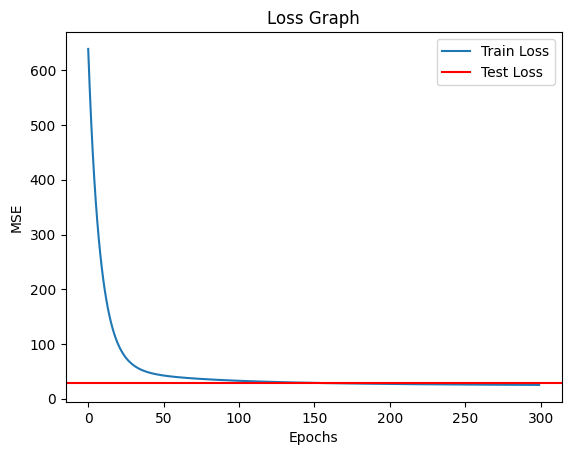

In [37]:
def check_data_preprocessing(x_train, y_train, x_test, y_test):
    # Check the shapes of input data
    print("Shapes of input data:")
    print(f"x_train shape: {x_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Check for any NaN or missing values in the data
    print("\nChecking for NaN or missing values:")
    if np.isnan(x_train).any() or np.isnan(y_train).any() or np.isnan(x_test).any() or np.isnan(y_test).any():
        print("Warning: Data contains NaN or missing values.")
    else:
        print("   Data does not contain NaN or missing values.")

    # Check data normalization (mean should be close to 0, standard deviation close to 1)
    print("\nChecking data normalization:")
    print(f"x_train mean: {np.mean(x_train)}")
    print(f"x_train std: {np.std(x_train)}")
    print(f"x_test mean: {np.mean(x_test)}")
    print(f"x_test std: {np.std(x_test)}")
def train_network():

  (x_train, y_train), (x_test, y_test) = load_data();

  # linear network
  # plot training and test loss over time in jupyter notebook
  losses = [];

  shapes = [x_train.shape[1], 1];
  outputs = ["linear"];
  model = initialize_weights(shapes, outputs);

  # what's the alpha you should use?

  alpha = 0.4;

  for i in range(300):
    fwd_results = forward(x_train, model);
    loss, dweights = backward(y_train, fwd_results, model, "mse");
    update(model, dweights, alpha);
    losses.append(loss);


  # Test
  ftest = forward(x_test, model)
  test_loss = backward(y_test, ftest, model, "mse")


  # Plot
  fig, ax = plt.subplots()
  time = np.arange(0, 300, 1)
  ax.plot(time, losses)
  plt.axhline(y=test_loss[0], color='red')
  plt.title("Loss Graph")
  plt.ylabel("MSE")
  plt.xlabel("Epochs")
  plt.legend(["Train Loss", "Test Loss"])



train_network();


- Change training function to collect training and test loss

# 2. Classification on Iris Dataset

In [38]:
import sklearn
from sklearn.model_selection import train_test_split

def load_iris():
  iris = datasets.load_iris()
  x = iris.data.astype(np.float32)
  y = iris.target

  y = to_categorical(y, np.max(y)+1).astype(np.float32)

  # (B,) -> {0, 1, 2}
  # (B, 3) -> 0 -> y[:, 0] = 1, 1 -> y[:, 1] = 1

  # need to do conditioning on the dataset
  # Will use test train split in sklearn

  x_train, x_test, y_train, y_test = train_test_split(x, y)
  x_train = sklpre.normalize(x_train, norm='max', axis=0)
  x_test = sklpre.normalize(x_test, norm='max', axis=0)

  return (x_train, y_train), (x_test, y_test)

[4, 30, 10, 3]
[0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.28571, 0.28571, 0.26786, 0.25893, 0.26786, 0.28571, 0.29464, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.32143, 0.33929, 0.33929, 0.33036, 0.32143, 0.32143, 0.32143, 0.3125, 0.3125, 0.3125, 0.3125, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357, 0.30357]


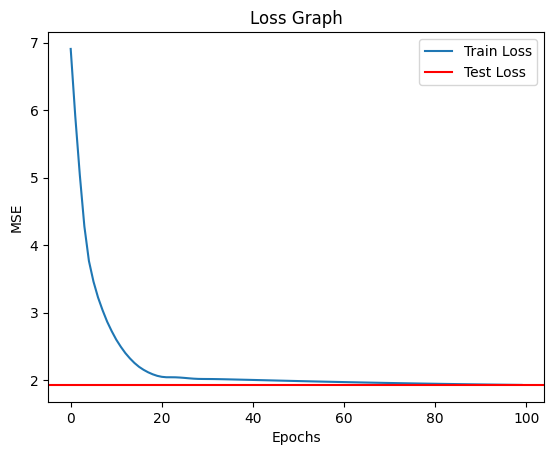

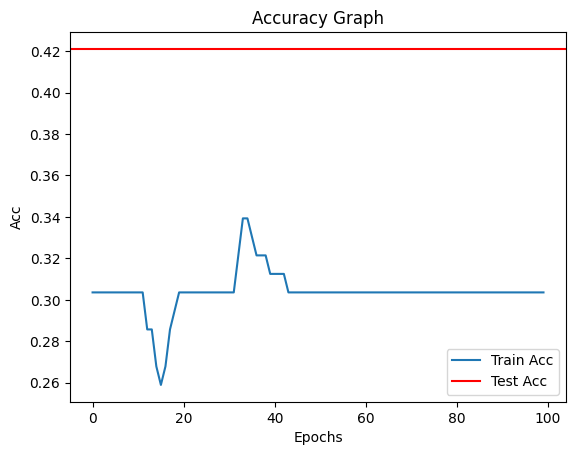

In [39]:
def accuracy(y, p): # (B, 3)
    # y = (1, 0, 0), p = (0.2, 0.5, 0.3)
    # y = 0, p = 1
    return np.mean(np.argmax(y, axis=-1) == np.argmax(p, axis=-1))

def train_network():
  (x_train, y_train), (x_test, y_test) = load_iris()

  # example of network. try your own to get higher accuracy
  # plot training and test loss over time in jupyter notebook
  # plot training and test accuracy over time in jupyter notebook

  outputs = ["relu", "relu", "sigmoid"]
  shapes = [x_train.shape[1], 30, 10, y_train.shape[1]]
  losses = []
  acc = []
  print(shapes)

  # which alpha should you use?

  alpha = 0.02
  model = initialize_weights(shapes, outputs)
  truth = np.argmax(y_train, axis=1)

  # Added extra epochs as higher training rates caused oscillation
  for i in range(100):
    fwd_res = forward(x_train, model)
    loss, dweights = backward(y_train, fwd_res, model, "binary_crossentropy")
    update(model, dweights, alpha)
    losses.append(loss)

    acc.append(np.around(np.divide(np.sum(np.argmax(predict(x_train, model),
                                      axis=1)==truth), truth.shape[0]), decimals=5))


  print(acc)
  # Test
  test_res = forward(x_test, model)
  test_loss = backward(y_test, test_res, model, "binary_crossentropy")
    # Pred
  test_pred = np.argmax(test_res[-1]["y"], axis=1)
  test_truth = np.argmax(y_test, axis=1)
  test_acc = np.around(np.divide(np.sum(test_pred==test_truth), test_truth.shape[0]),decimals=5)


  # Plot - Losses
  fig, ax = plt.subplots()
  time = np.arange(0, 100, 1)
  ax.plot(time, losses)
  plt.axhline(y=np.mean(test_loss[0]), color='red')
  plt.title("Loss Graph")
  plt.ylabel("MSE")
  plt.xlabel("Epochs")
  plt.legend(["Train Loss", "Test Loss"])

  # Plot - Accuracy
  fig, ax = plt.subplots()
  time = np.arange(0, 100, 1)
  ax.plot(time, acc)
  plt.axhline(y=test_acc, color='red')
  plt.title("Accuracy Graph")
  plt.ylabel("Acc")
  plt.xlabel("Epochs")
  plt.legend(["Train Acc", "Test Acc"])
train_network()

# 3. Packages These Days Use Automatic Differentiation Like AutoGrad

In [40]:
import autograd.numpy as np
from autograd import elementwise_grad as grad

In [41]:
x = np.arange(6).astype(np.float32)
x

array([0., 1., 2., 3., 4., 5.], dtype=float32)

In [42]:
def f(x):
    return 3.0 * np.power(x, 2) + 5.0 * x - 4.0

In [43]:
grad_f = grad(f)

In [44]:
grad_f(x)

array([ 5., 11., 17., 23., 29., 35.], dtype=float32)

In [45]:
(f(x + 0.01) - f(x - 0.01)) / 0.02

array([ 4.9999833, 11.000013 , 17.000008 , 22.999954 , 29.000473 ,
       35.001373 ], dtype=float32)

Now reimplement the `forward` and `backward` function using AutoGrad. We will give as example the example on how autograd facilitates computation of gradients.

Comments:

1. I said in the class to always check the shapes to see the operations. dw and w have transposed shapes.
2. If you look at the notes, you will see that y's and z's have the same shape
3. If you need to debug on the fly, put the following line in the code. You can search on the web but basically, you can do step by step computation with pdb.

```python
import pdb; pdb.set_trace()
```

In [46]:
!pip install autograd

[4, 30, 10, 3]
[0.35714, 0.55357, 0.59821, 0.63393, 0.63393, 0.57143, 0.58036, 0.60714, 0.61607, 0.64286, 0.65179, 0.65179, 0.65179, 0.65179, 0.65179, 0.65179, 0.65179, 0.65179, 0.65179, 0.65179, 0.64286, 0.64286, 0.64286, 0.64286, 0.64286, 0.63393, 0.63393, 0.61607, 0.625, 0.625, 0.63393, 0.625, 0.60714, 0.5625, 0.54464, 0.47321, 0.44643, 0.41964, 0.40179, 0.38393, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.36607, 0.36607, 0.36607, 0.36607, 0.36607, 0.36607, 0.35714, 0.35714, 0.35714, 0.35714, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.34821, 0.35714, 0.35714, 0.35714, 0.35714, 0.35714, 0.35714, 0.35714]


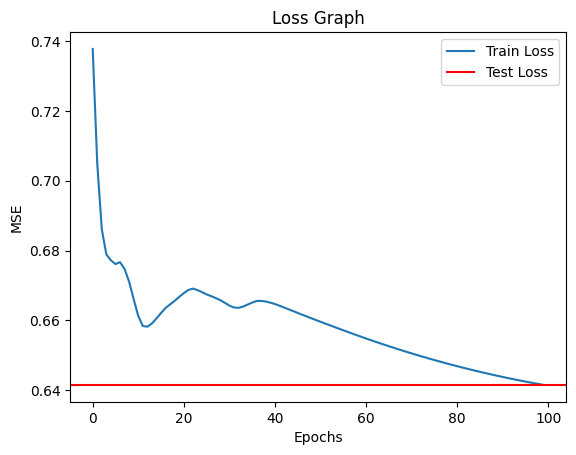

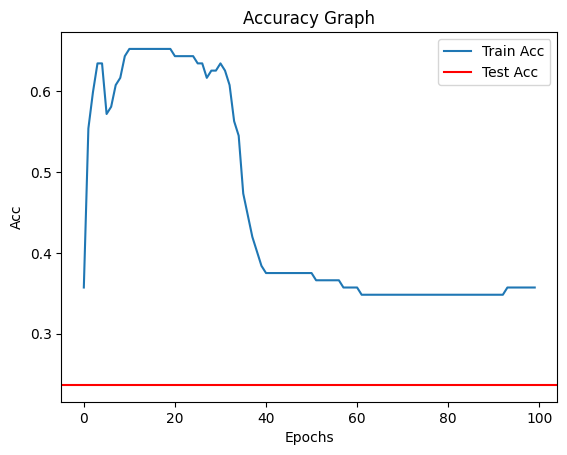

In [47]:
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad as egrad

def forward(x, model):
    result = [{"z": x, "y": x}]
    y = x
    for layer in model:
        # layer = [ w[i], b[i], 'relu']
        z = np.dot(y, layer[0]) + layer[1]  # (B,N1) + (N1,N2)
        y = activations[layer[2]](z)
        result.append({'y': y, 'z': z})
    return result

def backward(y, x, model, loss_fn):
    def mse(y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    def binary_crossentropy(y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    def loss(y_true, y_pred):
        if loss_fn == "mse":
            return mse(y_true, y_pred)
        elif loss_fn == "binary_crossentropy":
            return np.mean(binary_crossentropy(y_true, y_pred))

    loss_grad = grad(loss)
    weights = []
    y = y.reshape(x[-1]["y"].shape)

    loss_eval = loss(y, x[-1]["y"])
    dY = loss_grad(y, x[-1]["y"])

    for i, layer in reversed(list(enumerate(model))):
        new_dY = dY
        old_y = x[i]["y"]
        if layer[2] == "linear":
            dZ = new_dY
        elif layer[2] == "relu":
            dZ = egrad(lambda x: np.maximum(0, x))(x[i + 1]["z"])
        else:
            dZ = sigmoid(x[i + 1]["z"]) * (1 - sigmoid(x[i + 1]["z"]))
        dW = np.dot(old_y.T, dZ) / y.shape[0]
        dB = np.sum(dZ, axis=0, keepdims=True) / y.shape[0]
        old_dY = np.dot(dZ, layer[0].T)
        weights.insert(0, {"dw": dW, "db": dB})
    return (loss_eval, weights)

train_network();